In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as clr
import matplotlib.animation as animation
from tqdm import tqdm
#from scipy.optimize import minimize
#from scipy import optimize
#from jax.scipy.optimize import minimize
#from jax.scipy import optimize
#from scipy.linalg import circulant
#from scipy import fft
from joblib import Parallel, delayed
#import torch
#from cycler import cycler
#import torchvision
import cProfile
#from scipy import special
#from scipy.linalg import qr
#from scipy import sparse
import pickle 
import os


import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
def log_downsample_indices(total_points, num_points=1000):
    """
    Generate logarithmically spaced indices for downsampling.
    The indices are computed in the range [1, total_points] then converted to zero-indexed values.
    """
    indices = np.unique(np.round(np.geomspace(1, total_points, num=num_points)).astype(int)) - 1
    return indices

class TeacherStudentLearning:
    def __init__(self, input_dim, teacher_size, student_size, teacher_params, student_params_ini):
        self.input_dim = input_dim
        self.teacher_size = teacher_size
        self.student_size = student_size
        
        self.teacher_params = teacher_params.copy()
        self.student_params = student_params_ini.copy()
        
        # Initialize batch normalization parameters
        self.student_params['gamma1'] = np.ones(self.student_size)/2
        self.student_params['beta1'] = np.zeros(self.student_size)
        self.student_params['gamma2'] = np.ones(1)/2
        self.student_params['beta2'] = np.zeros(1)
        
        # Initialize batch normalization parameters
        self.teacher_params['gamma1'] = np.ones(self.teacher_size)/2
        self.teacher_params['beta1'] = np.zeros(self.teacher_size)
        self.teacher_params['gamma2'] = np.ones(1)/2
        self.teacher_params['beta2'] = np.zeros(1)



    def phi(self, x, nonlinearity):
        if nonlinearity == 'lin':
            return x
        elif nonlinearity == 'tanh':
            return np.tanh(x)
        elif nonlinearity == 'relu':
            return np.clip(x, a_min=0, a_max=None)
        elif nonlinearity == 'sigmoid':
            return 1/(1+np.exp(-x))
        else:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")

    def phi_p(self, x, nonlinearity):
        if nonlinearity == 'lin':
            return np.full_like(x, 1)
        elif nonlinearity == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif nonlinearity == 'relu':
            return (x > 0) * np.full_like(x, 1)
        elif nonlinearity == 'sigmoid':
            return np.exp(x)/(1+np.exp(x))**2
        else:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")

    def ff_pass(self, x, network_params, nonlinearity, batch_norm=True):
        W1, W2, D1, D2 = network_params['W1'], network_params['W2'], network_params['D1'], network_params['D2']
        
        if batch_norm:
            a1 = np.dot(W1, np.dot(D1, x))
            a1_bn = ((a1-a1.mean(axis = -1)[:,None])/(a1.std(axis = -1)[:,None]))*network_params['gamma1'][:,None]+network_params['beta1'][:,None]
            h = self.phi(a1_bn, nonlinearity)
            
            a2 = np.dot(W2, np.dot(D2, h))
            a2_bn = ((a2-a2.mean(axis = -1)[:,None])/(a2.std(axis = -1)[:,None]))*network_params['gamma2'][:,None]+network_params['beta2'][:,None]
            y = self.phi(a2_bn, nonlinearity)
        else:
            h = self.phi(np.dot(W1, np.dot(D1, x)), nonlinearity)
            y = self.phi(np.dot(W2, np.dot(D2, h)), nonlinearity)
        return y
            

    
    def error(self, input_list, nonlinearity, batch_norm):
        inputs = np.stack(input_list, axis=1)  # Combine inputs for batch processing
        y_hat = self.ff_pass(inputs, self.student_params, nonlinearity, batch_norm)
        y = self.ff_pass(inputs, self.teacher_params, nonlinearity, batch_norm)
        return 0.5 * np.mean((y_hat - y) ** 2)
    
    def learning_update(self, x, B, learning_rate, plasticity, nonlinearity, batch_norm, ):
        y_hat = self.ff_pass(x, self.student_params, nonlinearity, batch_norm)
        y = self.ff_pass(x, self.teacher_params, nonlinearity, batch_norm)
        e = y_hat - y
        
        if batch_norm :
            a = np.dot(self.student_params['W1'], np.dot(self.student_params['D1'], x))
            a = ((a-a.mean(axis = -1)[:,None])/(a.std(axis = -1)[:,None]))*self.student_params['gamma1'][:,None]+self.student_params['beta1'][:,None]
            h = self.phi(a, nonlinearity)   
        else:
            a = self.student_params['W1'] @ self.student_params['D1'] @ x
            h = self.phi(a, nonlinearity)
        
        
        if plasticity == 'GD':
            da2 = e
            da1 = (self.student_params['D2'] @ self.student_params['W2'].T @ da2) * self.phi_p(a, nonlinearity)
        elif plasticity == 'Hebb_DFA_inh_w_GD_feedback':
            da2 = e
            da1 = (self.student_params['D2'] @ self.student_params['W2'].T @ da2) * self.phi_p(a, nonlinearity)
        elif plasticity == 'DFA':
            da2 = e
            da1 = (B @ da2) * self.phi_p(a, nonlinearity)
        else:
            raise ValueError(f"Unknown plasticity: {plasticity}")

        # Compute weight updates by summing over the batch dimension (axis=1)
        dWs2 = -learning_rate * (da2 @ h.T) / da2.shape[1]
        dWs1 = -learning_rate * (da1 @ x.T) / da1.shape[1]
        
        return dWs1, dWs2
    
    def _normalize_weights(self, weights):
        # Normalize each row of the weight matrix to have a unit norm
        norms = np.linalg.norm(weights, axis=1, keepdims=True)  # L2 norm of each row
        return weights / (norms + 1e-8)  # Add epsilon to prevent division by zero



    def learning_simu_batch(self, input_list, input_test_list, batch_size, nb_epochs, B, learning_rate, plasticity, nonlinearity, normalize_weights=True, batch_norm=True,  test_set=False):
        """
        Simulates the learning process with batch updates.

        Args:
            input_list: List of input samples.
            batch_size: Size of each batch.
            nb_epochs: Number of training epochs.
            B: Feedback alignment matrix.
            learning_rate: Learning rate.
            plasticity: Type of plasticity ('GD' or 'DFA').
            nonlinearity: Nonlinearity function.
            normalize_weights: Whether to normalize weights after each batch update.

        Returns:
            Ws1_hist: History of W1 updates.
            Ws2_hist: History of W2 updates.
            error_hist: History of error.
        """
        inputs = np.stack(input_list, axis=1)  # Stack inputs into a single matrix (shape: input_dim x total_samples)
        total_samples = inputs.shape[1]

        Ws1_hist = [self.student_params['W1'].copy()]
        Ws2_hist = [self.student_params['W2'].copy()]
        error_hist = [self.error(input_list[:batch_size], nonlinearity, batch_norm)]
        if test_set:
            test_error_hist = [self.error(input_test_list, nonlinearity, batch_norm)]
        else:
            test_error_hist = np.zeros_like(np.array(error_hist))

            
            
        log_indices = log_downsample_indices(nb_epochs, num_points=10000)
        ind = 1
        
        for epoch in range(nb_epochs):
            # Shuffle the data at the start of each epoch
            indices = np.random.permutation(total_samples)
            shuffled_inputs = inputs[:, indices]

            for start_idx in range(0, total_samples, batch_size):
                # Define batch range
                end_idx = min(start_idx + batch_size, total_samples)
                batch = shuffled_inputs[:, start_idx:end_idx]
                
                dWs1_avg, dWs2_avg = self.learning_update(batch, B, learning_rate, plasticity, nonlinearity, batch_norm)

                # Update weights
                self.student_params['W1'] += dWs1_avg
                self.student_params['W2'] += dWs2_avg

                # Enforce weight normalization
                if normalize_weights:
                    self.student_params['W1'] = self._normalize_weights(self.student_params['W1'])
                    self.student_params['W2'] = self._normalize_weights(self.student_params['W2'])

                if epoch == log_indices[ind]:
                    # Record history
                    Ws1_hist.append(self.student_params['W1'].copy())
                    Ws2_hist.append(self.student_params['W2'].copy())
                    
                    error_hist.append(self.error([batch[:, i] for i in range(batch.shape[1])], nonlinearity, batch_norm))  # Evaluate on the first sample of the batch [batch[:, 0]]
                    if test_set:
                        test_error_hist.append(self.error(input_test_list, nonlinearity, batch_norm))
            
                    ind+=1


        return np.array(Ws1_hist), np.array(Ws2_hist), np.array(error_hist), np.array(test_error_hist)


    
    def learning_simu(self, input_list, B, learning_rate, plasticity, nonlinearity):
        Ws1_hist = [self.student_params['W1'].copy()]
        Ws2_hist = [self.student_params['W2'].copy()]
        error_hist = [self.error([input_list[0]], nonlinearity)]
        
        for x in input_list:
            dWs1, dWs2 = self.learning_update(x, B, learning_rate, plasticity, nonlinearity)
            self.student_params['W1'] += dWs1
            self.student_params['W2'] += dWs2
            
            Ws1_hist.append(self.student_params['W1'].copy())
            Ws2_hist.append(self.student_params['W2'].copy())
            error_hist.append(self.error([x], nonlinearity))
        
        return np.array(Ws1_hist), np.array(Ws2_hist), np.array(error_hist)

    
def find_timestep_below_threshold(errors, thresh):
    """
    Find the timestep at which the error gets below a threshold value.

    Parameters:
    errors (numpy.ndarray): Array of error values.
    thresh (float): Threshold value.

    Returns:
    int: The timestep at which the error gets below the threshold, or -1 if it never does.
    """
    # Find the indices where the error is below the threshold
    below_threshold_indices = np.where(errors < thresh)[0]

    # If there are no such indices, return -1
    if below_threshold_indices.size == 0:
        return -1

    # Return the first index where the error is below the threshold
    return below_threshold_indices[0]

In [3]:
label_list = ['GD', 'DFA', 'DFA with inhibitory', 'Hebb DFA inh with GD feedback']
plasticity_list = ['GD', 'DFA', 'DFA', 'Hebb_DFA_inh_w_GD_feedback']



with open('run_8-25__0-84__8.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

params_dic, input_list, input_test_list, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data



nb_data_points = params_dic['nb_data_points']
nb_test_data_points = params_dic['nb_test_data_points'] 
input_dim = params_dic['input_dim']
teacher_size = params_dic['teacher_size']
student_size = params_dic['student_size']
nb_AH_layer1 = params_dic['nb_AH_layer1']
nb_AH_layer2 = params_dic['nb_AH_layer2']
nb_epochs = params_dic['nb_epochs']
nb_init = params_dic['nb_init']
nonlinearity_list = params_dic['nonlinearity_list']
learning_rate = params_dic['learning_rate']
B_dic =  params_dic['B_dic']

log_indices = np.arange(0,nb_epochs)# log_downsample_indices(nb_epochs, num_points=100)


#color_list = ['blue', 'orange', 'green', 'red']
color_list = ['#790992', '#C65D0A', '#fab16c', '#c385d1']

In [4]:
#params_dic

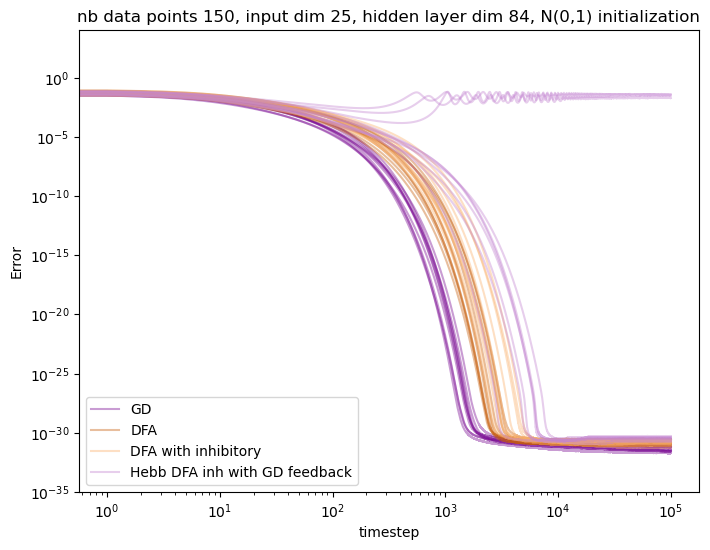

In [5]:
plt.figure(figsize=(8, 6))

for i in range(len(label_list)):
    # Plot the first run with a legend entry.
    errors = np.array(error_hist_dic[label_list[i]])[0].round(35)
    plt.plot(log_indices, errors, label=label_list[i], color=color_list[i], alpha=0.4)
    
    # Plot subsequent runs without legend entries.
    for j in range(1, nb_init):
        errors = np.array(error_hist_dic[label_list[i]])[j].round(35)
        plt.plot(log_indices, errors, color=color_list[i], alpha=0.4)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel('timestep')
plt.legend(loc='lower left')
plt.ylim((1e-35, 1e4))
plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save the figure with a lower DPI to further reduce file size
#plt.savefig('loglog_lin_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_N(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=72)
plt.show()

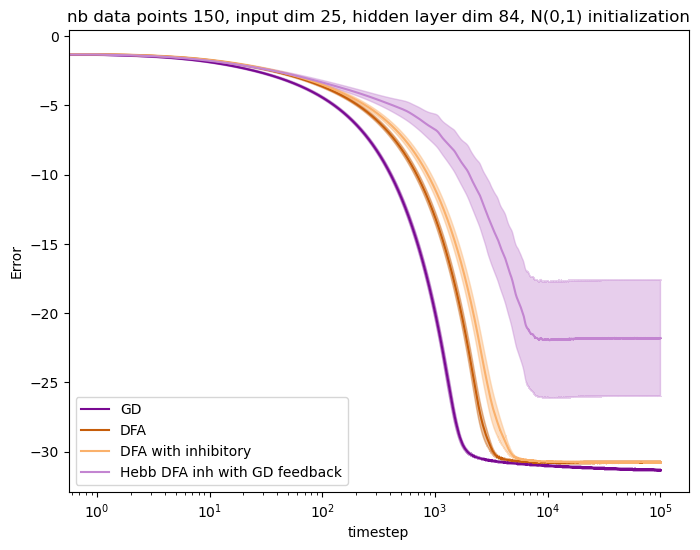

In [28]:


plt.figure(figsize=(8, 6))

for i, label in enumerate(label_list):
    # Convert error histories to a numpy array: shape (nb_init, timesteps)
    errors = np.log10(np.array(error_hist_dic[label]))#.round(15) + 1e-15)
    
    # Compute average and SEM across runs (axis 0)
    avg_error = np.mean(errors, axis=0)
    sem_error = np.std(errors, axis=0) / np.sqrt(errors.shape[0])
  

    # Plot the average error curve
    plt.plot(log_indices, avg_error, label=label, color=color_list[i])
    # Add the shaded region (mean ± SEM)
    plt.fill_between(log_indices, avg_error - sem_error, avg_error + sem_error,
                     color=color_list[i], alpha=0.4)

#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Error')
plt.xlabel('timestep')
plt.legend(loc='lower left')
#plt.ylim((1e-14, 1e4))
plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save with a lower DPI to further reduce file size
#plt.savefig('avg_train_loglog_tanh_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_N(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=72)
plt.show()


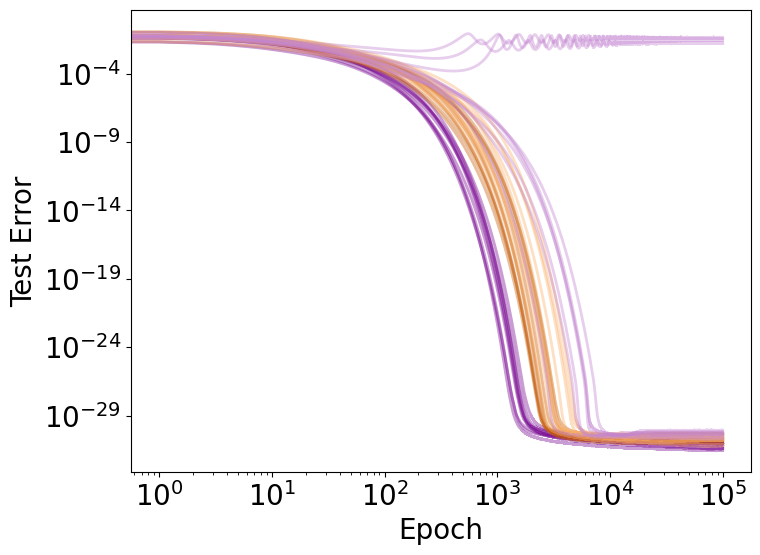

In [29]:

plt.figure(figsize=(8, 6))

for i in range(len(label_list)):
    # Plot the first run with a legend entry.
    errors = np.array(test_error_hist_dic[label_list[i]])[0]#.round(15)
    plt.plot(log_indices, errors, label=label_list[i], color=color_list[i], alpha=0.4, linewidth = 2)
    
    # Plot subsequent runs without legend entries.
    for j in range(1, nb_init):
        errors = np.array(test_error_hist_dic[label_list[i]])[j]#.round(15)
        plt.plot(log_indices, errors, color=color_list[i], alpha=0.4, linewidth =2)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Test Error', fontsize=20)
plt.xlabel('Epoch', fontsize = 20)
#plt.legend(loc='lower left')
#plt.ylim((1e-14, 1e4))
#plt.title('nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
#          % (nb_data_points, input_dim, student_size))
plt.tick_params(axis='both', which='major', labelsize=20)
# Save the figure with a lower DPI to further reduce file size
#plt.savefig('tanhlearning_curves_poster_high_data_regime.pdf', dpi=300, bbox_inches='tight')
plt.show()

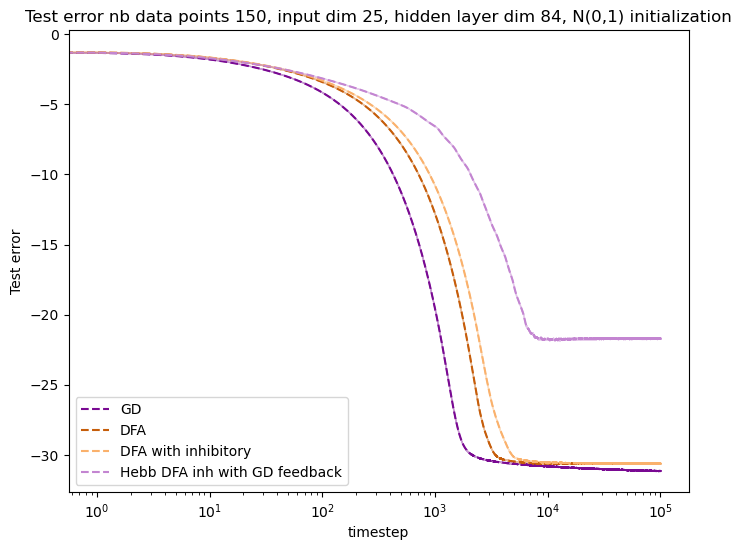

In [30]:


plt.figure(figsize=(8, 6))

for i, label in enumerate(label_list):
    # Convert error histories to a numpy array: shape (nb_init, timesteps)
    test_errors = np.log10(np.array(test_error_hist_dic[label]))#.round(15) + 1e-15)
    
    # Compute average and SEM across runs (axis 0)
    avg_error = np.mean(test_errors, axis=0)
    sem_error = np.std(test_errors, axis=0) / np.sqrt(errors.shape[0])
    
    # Plot the average error curve
    plt.plot(log_indices, avg_error, label=label, color=color_list[i], linestyle="--")
    # Add the shaded region (mean ± SEM)
    plt.fill_between(log_indices, avg_error - sem_error, avg_error + sem_error,
                     color=color_list[i], alpha=0.4)

#plt.yscale('log')
plt.xscale('log')
plt.ylabel('Test error')
plt.xlabel('timestep')
plt.legend(loc='lower left')
#plt.ylim((1e-14, 1e4))
plt.title('Test error nb data points %d, input dim %d, hidden layer dim %d, N(0,1) initialization'
          % (nb_data_points, input_dim, student_size))

# Save with a lower DPI to further reduce file size
#plt.savefig('avg_test_loglog_tanh_nb_data_points_%d_input_dim_%d_hidden_layer_dim_%d_N(0,1)_initialization.pdf' % (nb_data_points, input_dim, student_size), dpi=72)
plt.show()


In [6]:
def list_pkl_files(directory="."):
    try:
        # List all files and directories in the specified directory
        files_and_dirs = os.listdir(directory)

        # Filter out directories and non-.pkl files, keep only .pkl files
        pkl_files = [f for f in files_and_dirs if os.path.isfile(os.path.join(directory, f)) and f.endswith('.pkl')]

        return pkl_files
    except Exception as e:
        return str(e)

# Example usage
pkl_files = list_pkl_files()
len(pkl_files)

210

In [7]:
pkl_files

['run_41-62__0-157__41.pkl',
 'run_21-73__0-146__57.pkl',
 'run_28-31__0-78__47.pkl',
 'run_19-31__0-78__40.pkl',
 'run_26-53__0-166__102.pkl',
 'run_54-90__0-129__134.pkl',
 'run_3-31__0-78__28.pkl',
 'run_63-73__0-146__71.pkl',
 'run_15-30__0-189__97.pkl',
 'run_66-73__0-146__72.pkl',
 'run_15-62__0-157__31.pkl',
 'run_10-25__0-194__76.pkl',
 'run_35-71__0-148__107.pkl',
 'run_15-73__0-146__55.pkl',
 'run_30-73__0-146__60.pkl',
 'run_42-85__0-134__112.pkl',
 'run_25-62__0-157__35.pkl',
 'run_25-50__0-169__12.pkl',
 'run_17-35__0-184__98.pkl',
 'run_20-50__0-169__10.pkl',
 'run_32-64__0-155__105.pkl',
 'run_4-36__0-73__53.pkl',
 'run_0-31__0-78__25.pkl',
 'run_28-71__0-148__87.pkl',
 'run_45-90__0-129__114.pkl',
 'run_23-31__0-78__43.pkl',
 'run_0-25__0-84__0.pkl',
 'run_25-64__0-155__85.pkl',
 'run_20-62__0-157__33.pkl',
 'run_27-31__0-78__46.pkl',
 'run_22-25__0-84__22.pkl',
 'run_19-49__0-170__81.pkl',
 'run_18-30__0-189__117.pkl',
 'run_18-25__0-84__18.pkl',
 'run_20-40__0-179__99

In [8]:
log_indices = np.arange(0,nb_epochs)#log_downsample_indices(nb_epochs, num_points=100)
log_indices_whist = np.arange(0,1000)


nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,0,20)
c_list_L2 = np.logspace(-2,0,20)


frac_list = np.linspace(0, 1, num = 11)
tot_neurons = 110

for c in c_list_L1 :
    N = int(tot_neurons/(1+c))
    M = int(tot_neurons/(1+1/c))
    
    frac_L1 = 0.3
    nb_AH_layer2 = 0#int(N*frac_L2) # 0
    nb_AH_layer1 = int(M*frac_L1)#0

    filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])

#[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]


q_mat_L1 = []


for file in filtered_list:
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)
    params_dic, input_list, input_test_list, Ws1_hist_dic, Ws2_hist_dic, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data
    
    nb_data_points = params_dic['nb_data_points']
    nb_test_data_points = params_dic['nb_test_data_points'] 
    input_dim = params_dic['input_dim']
    teacher_size = params_dic['teacher_size']
    student_size = params_dic['student_size']
    nb_AH_layer1 = params_dic['nb_AH_layer1']
    nb_AH_layer2 = params_dic['nb_AH_layer2']
    nb_epochs = params_dic['nb_epochs']
    nb_init = params_dic['nb_init']
    nonlinearity_list = params_dic['nonlinearity_list']
    learning_rate = params_dic['learning_rate']

    nb_datpoints_list.append(nb_data_points)
    error_hist_dic_list.append(error_hist_dic)
    test_error_hist_dic_list.append(test_error_hist_dic)
    
    nb_ts_hist = 999

    q_list = np.zeros(nb_init)

    for trial in range(nb_init):
        w1_hist = Ws1_hist_dic[label_list[3]][trial][1:]
        w2_hist = Ws2_hist_dic[label_list[3]][trial][1:]

        all_w_hist = np.concatenate((w1_hist.reshape(nb_ts_hist, student_size*input_dim ), 
                               w2_hist.reshape(nb_ts_hist, student_size)), axis = 1)

        all_w_mean_hist = np.nanmean(all_w_hist,axis = 0)
        all_w_centered_hist = all_w_hist - all_w_mean_hist
        all_w_centered_hist -= np.nanmean(all_w_centered_hist, axis = 0)
        
        var_w_hist = all_w_centered_hist**2

        qtrial = var_w_hist.mean()/all_w_mean_hist.std()

        q_list[trial] = qtrial
    q_mat_L1.append(q_list)

IndexError: list index out of range

In [ ]:
q_mat_L1 = np.array(q_mat_L1)
np.nanmean(q_mat_L1, axis = 1)

In [34]:
c_list_L1

array([0.1       , 0.11288379, 0.1274275 , 0.14384499, 0.16237767,
       0.18329807, 0.20691381, 0.23357215, 0.26366509, 0.29763514,
       0.33598183, 0.37926902, 0.42813324, 0.48329302, 0.54555948,
       0.61584821, 0.6951928 , 0.78475997, 0.88586679, 1.        ])

In [35]:
log_indices = np.arange(0,nb_epochs)#log_downsample_indices(nb_epochs, num_points=100)
log_indices_whist = np.arange(0,1000)


nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,0,20)
c_list_L2 = np.logspace(-2,0,20)

frac_list = np.linspace(0, 1, num = 11)
tot_neurons = 110

for c in c_list_L2 :
    N = int(tot_neurons/(1+c))
    M = int(tot_neurons/(1+1/c))
    
    frac_L2 = 0.3
    nb_AH_layer2 = int(N*frac_L2) # 0
    nb_AH_layer1 = 0#int(M*frac_L1)#0

    filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])

#[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]


q_mat_L2 = []


for file in filtered_list:
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)
    params_dic, input_list, input_test_list, Ws1_hist_dic, Ws2_hist_dic, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data
    
    nb_data_points = params_dic['nb_data_points']
    nb_test_data_points = params_dic['nb_test_data_points'] 
    input_dim = params_dic['input_dim']
    teacher_size = params_dic['teacher_size']
    student_size = params_dic['student_size']
    nb_AH_layer1 = params_dic['nb_AH_layer1']
    nb_AH_layer2 = params_dic['nb_AH_layer2']
    nb_epochs = params_dic['nb_epochs']
    nb_init = params_dic['nb_init']
    nonlinearity_list = params_dic['nonlinearity_list']
    learning_rate = params_dic['learning_rate']

    nb_datpoints_list.append(nb_data_points)
    error_hist_dic_list.append(error_hist_dic)
    test_error_hist_dic_list.append(test_error_hist_dic)
    
    nb_ts_hist = 999

    q_list = np.zeros(nb_init)

    for trial in range(nb_init):
        w1_hist = Ws1_hist_dic[label_list[3]][trial][1:]
        w2_hist = Ws2_hist_dic[label_list[3]][trial][1:]

        all_w_hist = np.concatenate((w1_hist.reshape(nb_ts_hist, student_size*input_dim ), 
                               w2_hist.reshape(nb_ts_hist, student_size)), axis = 1)

        all_w_mean_hist = all_w_hist.mean(axis = 0)
        all_w_centered_hist = all_w_hist - all_w_mean_hist
        all_w_centered_hist -= all_w_centered_hist.mean(axis = 0)
        
        var_w_hist = all_w_centered_hist**2

        qtrial = var_w_hist.mean()/all_w_mean_hist.std()

        q_list[trial] = qtrial
        q_list[trial] = qtrial
    q_mat_L2.append(q_list)
    
q_mat_L2= np.array(q_mat_L2)

IndexError: list index out of range

In [36]:
all_w_hist.var(axis = 0).shape

NameError: name 'all_w_hist' is not defined

In [ ]:
55*55+55

In [37]:
plt.plot(c_list_L1, np.median(q_mat_L1, axis = 1), color = 'lightsteelblue', label = 'Layer 1')
plt.plot(c_list_L2, np.median(q_mat_L2, axis = 1), color ='lightcoral', label = "Layer 2")

plt.xscale('log')
plt.yscale('log')

plt.ylabel('q order parameter')
plt.xlabel('$M/N$ ratio')

plt.legend()

plt.title('AH ratio set to 0.3')

NameError: name 'q_mat_L1' is not defined

In [38]:
c = 0.1
frac_list = np.linspace(0, 1, num = 11)

for frac_L2 in frac_list:
    N = int(tot_neurons/(1+c))
    M = int(tot_neurons/(1+1/c))
    
    #frac_L2 = 0.3
    nb_AH_layer1 = 0
    nb_AH_layer2 = int(N*frac_L2)


In [39]:
log_indices = np.arange(0,nb_epochs)#log_downsample_indices(nb_epochs, num_points=100)
log_indices_whist = np.arange(0,1000)


nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,0,20)
c_list_L2 = np.logspace(-2,0,20)

frac_list = np.linspace(0, 1, num = 25)
tot_neurons = 110

c_list = [0.1, 0.2, 0.3]
q_tens_L2 = []

for c in c_list:
    filtered_list = []

    for frac_L2 in frac_list:
        N = int(tot_neurons/(1+c))
        M = int(tot_neurons/(1+1/c))

        nb_AH_layer2 = int(N*frac_L2) # 0
        nb_AH_layer1 = 0#int(M*frac_L1)#0

        filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])

    #[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]
    
    q_mat_L2u = []
        

    for file in filtered_list:
        with open(file, 'rb') as f:
            loaded_data = pickle.load(f)
        params_dic, input_list, input_test_list, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data

        nb_data_points = params_dic['nb_data_points']
        nb_test_data_points = params_dic['nb_test_data_points'] 
        input_dim = params_dic['input_dim']
        teacher_size = params_dic['teacher_size']
        student_size = params_dic['student_size']
        nb_AH_layer1 = params_dic['nb_AH_layer1']
        nb_AH_layer2 = params_dic['nb_AH_layer2']
        nb_epochs = params_dic['nb_epochs']
        nb_init = params_dic['nb_init']
        nonlinearity_list = params_dic['nonlinearity_list']
        learning_rate = params_dic['learning_rate']

        nb_datpoints_list.append(nb_data_points)
        error_hist_dic_list.append(error_hist_dic)
        test_error_hist_dic_list.append(test_error_hist_dic)

        nb_ts_hist = 999

        
        q_list = params_dic['q_list']
        q_mat_L2u.append(q_list)
    q_mat_L2u = np.array(q_mat_L2u)
    
    q_tens_L2.append(q_mat_L2u)

IndexError: list index out of range

In [641]:
L2_results = np.load('L2_results.npy', allow_pickle = True)
mask_mat_all_stable, mask_mat_some_stable, AH_L2_frac_list, AH_L2_upper_frac_list = L2_results

Z_th = mask_mat_all_stable.astype(int) 
x_vals = np.logspace(-3, 2, num=500)
y_vals = np.linspace(0,1, mask_mat_all_stable.shape[1])

crit_frac_list = []

for c in c_list:

    ind_x_vals = np.max(np.where(x_vals < c))
    crit_frac_ind = np.max(np.where(Z_th[ind_x_vals, :]<0.5))
    crit_frac = y_vals[crit_frac_ind]
    crit_frac_list.append(crit_frac)

In [642]:
crit_frac

0.13827655310621242

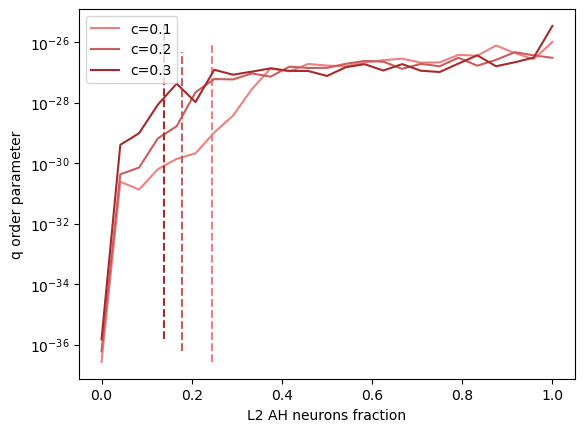

In [643]:
q_tens_L2 = np.array(q_tens_L2)

colorlist = ['lightcoral', 'indianred', 'brown']

for i,c in enumerate(c_list):
    
    plt.plot(frac_list, np.median(q_tens_L2[i],axis=1), color=colorlist[i], label = f'c={c}')

    plt.vlines(x=crit_frac_list[i], ymin = np.nanmedian(q_tens_L2[i],axis=1).min(),ymax = np.nanmedian(q_tens_L2[i],axis=1).max(), linestyles= '--', color =colorlist[i])

    
plt.yscale('log')

plt.ylabel('q order parameter')
plt.xlabel('L2 AH neurons fraction')
plt.legend()
#plt.title('$c=0.1$')

#plt.savefig('q_vs_L2frac_c=0.1-0.2-0.3.png' , dpi=300)

In [601]:
len(q_tens_L2)

3

In [8]:
log_indices = np.arange(0,nb_epochs)#log_downsample_indices(nb_epochs, num_points=100)
log_indices_whist = np.arange(0,1000)


nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,0,20)
c_list_L2 = np.logspace(-2,0,20)

frac_list = np.linspace(0, 1, num = 25)
tot_neurons = 220

c_list = [0.3, 0.4, 0.5]

q_tens_L1 = []

for c in c_list:
    
    filtered_list = []
    
    for frac_L1 in frac_list:
        N = int(tot_neurons/(1+c))
        M = int(tot_neurons/(1+1/c))

        nb_AH_layer2 = 0#int(N*frac_L2) # 0
        nb_AH_layer1 = int(M*frac_L1)#0

        filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])

    #[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]


    q_mat_L1u = []


    for file in filtered_list:
        with open(file, 'rb') as f:
            loaded_data = pickle.load(f)
        params_dic, input_list, input_test_list, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data

        nb_data_points = params_dic['nb_data_points']
        nb_test_data_points = params_dic['nb_test_data_points'] 
        input_dim = params_dic['input_dim']
        teacher_size = params_dic['teacher_size']
        student_size = params_dic['student_size']
        nb_AH_layer1 = params_dic['nb_AH_layer1']
        nb_AH_layer2 = params_dic['nb_AH_layer2']
        nb_epochs = params_dic['nb_epochs']
        nb_init = params_dic['nb_init']
        nonlinearity_list = params_dic['nonlinearity_list']
        learning_rate = params_dic['learning_rate']

        nb_datpoints_list.append(nb_data_points)
        error_hist_dic_list.append(error_hist_dic)
        test_error_hist_dic_list.append(test_error_hist_dic)

        nb_ts_hist = 999


        q_list = params_dic['q_list']
        q_mat_L1u.append(q_list)
    q_mat_L1u = np.array(q_mat_L1u)
    
    q_tens_L1.append(q_mat_L1u)
    

In [9]:
L1_results = np.load('L1_results.npy', allow_pickle = True)
mask_mat_all_stable, mask_mat_some_stable, AH_L1_frac_list, AH_L1_upper_frac_list = L1_results

Z_th = mask_mat_all_stable.astype(int) 
x_vals = np.logspace(-3, 2, num=500)
y_vals = np.linspace(0,1, mask_mat_all_stable.shape[1])

crit_frac_list = []

for c in c_list:
    

    ind_x_vals = np.max(np.where(x_vals < c))
    crit_frac_ind = np.max(np.where(Z_th[ind_x_vals, :]<0.5))
    crit_frac = y_vals[crit_frac_ind]
    crit_frac_list.append(crit_frac)

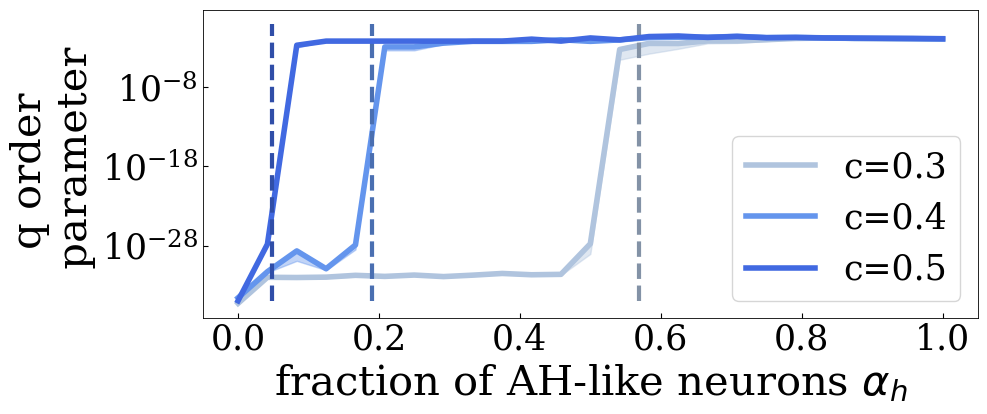

In [20]:

from matplotlib import rcParams, colors as mcolors

rcParams.update({
    "font.family": "serif",
    "font.size": 9,
    "axes.linewidth": 0.6,
    "axes.spines.right": True,
    "axes.spines.top": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

plt.figure(figsize=(10, 4))



q_tens_L1 = np.array(q_tens_L1)

colorlist = ['lightsteelblue', 'cornflowerblue', 'royalblue']

for i,c in enumerate(c_list):
    
    avg_q = np.nanmean(q_tens_L1[i],axis=1)
    sem_q = np.nanstd(q_tens_L1[i], axis=1)/np.sqrt(q_tens_L1.shape[2])
    
    plt.plot(frac_list, avg_q, color=colorlist[i], label = f'c={c}', linewidth = 4)

    plt.fill_between(frac_list, avg_q - sem_q, avg_q + sem_q,
                     color=colorlist[i], alpha=0.4)
    
    plt.vlines(x=crit_frac_list[i], ymin = 10**(-35),ymax =1, color =colorlist[i], linestyles ='--', linewidth =3)
    plt.vlines(x=crit_frac_list[i], ymin = 10**(-35),ymax =1, color ='k',alpha = 0.25,  linestyles ='--', linewidth =3)


plt.yscale('log')
plt.legend(fontsize=25, frameon=True, framealpha=0.8)

plt.ylabel('q order \n parameter', fontsize = 30)
plt.xlabel(r'fraction of AH-like neurons $\alpha_h$', fontsize = 30)

plt.tick_params(axis='both', which='major', labelsize=25)


#plt.savefig('q_vs_L1frac_c=0.3-0.4-0.5.png' , dpi=300,  bbox_inches = 'tight', transparent= True)
#plt.savefig('q_vs_L1frac_c=0.3-0.4-0.5.pdf' , dpi=300,  bbox_inches = 'tight', transparent= True)
#plt.savefig('q_vs_L1frac_c=0.3-0.4-0.5.svg' , dpi=300,  bbox_inches = 'tight', transparent= True)

In [81]:
log_indices = np.arange(0,nb_epochs)#log_downsample_indices(nb_epochs, num_points=100)
log_indices_whist = np.arange(0,1000)


nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,0,20)
c_list_L2 = np.logspace(-2,0,20)

c_list = np.linspace(0.1,0.7, num = 20)

#frac_list = np.linspace(0, 1, num = 25)
tot_neurons = 220

frac_list = [0.4, 0.5, 0.6]

q_tens_L1 = []

for frac_L1 in frac_list:
    
    filtered_list = []
    
    for c in c_list:
        N = int(tot_neurons/(1+c))
        M = int(tot_neurons/(1+1/c))

        nb_AH_layer2 = 0#int(N*frac_L2) # 0
        nb_AH_layer1 = int(M*frac_L1)#0

        filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])

    #[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]


    q_mat_L1u = []


    for file in filtered_list:
        with open(file, 'rb') as f:
            loaded_data = pickle.load(f)
        params_dic, input_list, input_test_list, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data

        nb_data_points = params_dic['nb_data_points']
        nb_test_data_points = params_dic['nb_test_data_points'] 
        input_dim = params_dic['input_dim']
        teacher_size = params_dic['teacher_size']
        student_size = params_dic['student_size']
        nb_AH_layer1 = params_dic['nb_AH_layer1']
        nb_AH_layer2 = params_dic['nb_AH_layer2']
        nb_epochs = params_dic['nb_epochs']
        nb_init = params_dic['nb_init']
        nonlinearity_list = params_dic['nonlinearity_list']
        learning_rate = params_dic['learning_rate']

        nb_datpoints_list.append(nb_data_points)
        error_hist_dic_list.append(error_hist_dic)
        test_error_hist_dic_list.append(test_error_hist_dic)

        nb_ts_hist = 999


        q_list = params_dic['q_list']
        q_mat_L1u.append(q_list)
    q_mat_L1u = np.array(q_mat_L1u)
    
    q_tens_L1.append(q_mat_L1u)
    

In [82]:
L1_results = np.load('L1_results.npy', allow_pickle = True)
mask_mat_all_stable, mask_mat_some_stable, AH_L1_frac_list, AH_L1_upper_frac_list = L1_results

Z_th = mask_mat_all_stable.astype(int) 
x_vals = np.logspace(-3, 2, num=500)
y_vals = np.linspace(0,1, mask_mat_all_stable.shape[1])

crit_c_list = []

for frac_L1 in frac_list:
    

    ind_y_vals = np.max(np.where(y_vals < frac_L1))
    crit_c_ind = np.max(np.where(Z_th[:,ind_y_vals]<0.5))
    crit_c = x_vals[crit_c_ind]
    crit_c_list.append(crit_c)

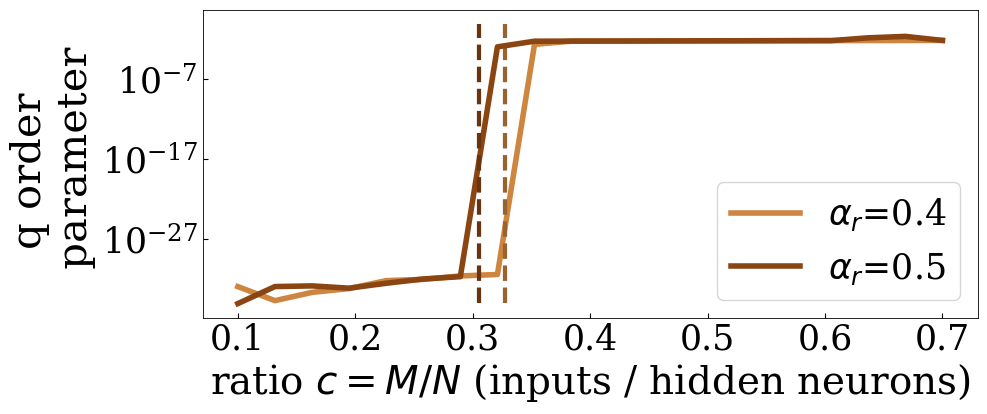

In [98]:

from matplotlib import rcParams, colors as mcolors

rcParams.update({
    "font.family": "serif",
    "font.size": 9,
    "axes.linewidth": 0.6,
    "axes.spines.right": True,
    "axes.spines.top": True,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

plt.figure(figsize=(10, 4))



q_tens_L1 = np.array(q_tens_L1)

colorlist = ['peru', 'saddlebrown']#'sandybrown', 

for i,frac_L1 in enumerate(frac_list):
    if i in [0,1]:
        plt.plot(c_list, np.nanmean(q_tens_L1[i],axis=1), color=colorlist[i], label = r'$\alpha_r$'+f'={frac_L1}', linewidth = 4)

        plt.vlines(x=crit_c_list[i], ymin = 10**(-35),ymax =1, color =colorlist[i], linestyles ='--', linewidth =3)
        plt.vlines(x=crit_c_list[i], ymin = 10**(-35),ymax =1, color ='k',alpha = 0.25,  linestyles ='--', linewidth =3)


plt.yscale('log')
plt.legend(fontsize=25, frameon=True, framealpha=0.8, loc='lower right')

plt.ylabel('q order \n parameter', fontsize = 30)
plt.xlabel('ratio $c=M/N$ (inputs / hidden neurons)', fontsize = 28)

plt.tick_params(axis='both', which='major', labelsize=25)


#plt.savefig('q_vs_c_fracL1=0.4-0.5.png' , dpi=300,  bbox_inches = 'tight', transparent= True)
#plt.savefig('q_vs_c_fracL1=0.4-0.5.pdf' , dpi=300,  bbox_inches = 'tight', transparent= True)
#plt.savefig('q_vs_c_fracL1=0.4-0.5.svg' , dpi=300,  bbox_inches = 'tight', transparent= True)

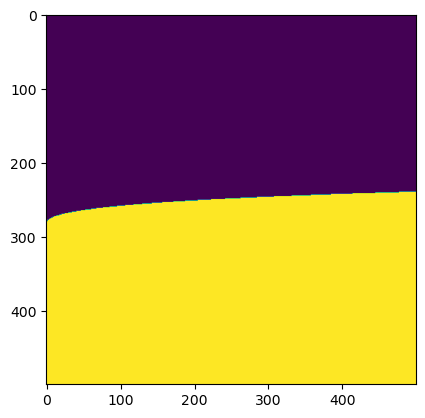

In [556]:
plt.imshow(Z_th)

In [482]:
lenlist = len(nb_datpoints_list)

err_nbdat_mean = np.zeros((4,lenlist))
err_nbdat_std = np.zeros((4,lenlist))

test_err_nbdat_mean = np.zeros((4,lenlist))
test_err_nbdat_std = np.zeros((4,lenlist))

ts_train_nbdat_mean = np.zeros((4,lenlist))
ts_train_nbdat_std = np.zeros((4,lenlist))

ts_test_nbdat_mean = np.zeros((4,lenlist))
ts_test_nbdat_std = np.zeros((4,lenlist))


timestep = -1
log_indices[timestep]

199999

In [166]:
errors = np.log10(np.array(error_hist_dic_list[0]['GD']).round(15)+1e-15)

thresh =-10# -1

ts_blw_thr = find_timestep_below_threshold(errors[0], thresh = thresh)

for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        ts_train_list = log_indices[np.array([find_timestep_below_threshold(error[k], thresh = thresh) for k in range(error.shape[0])])]
        
        ts_train_nbdat_mean[j,i] = ts_train_list.mean()
        ts_train_nbdat_std[j,i] = ts_train_list.std()
        
    
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        ts_test_list = log_indices[np.array([find_timestep_below_threshold(test_error[k], thresh = thresh) for k in range(test_error.shape[0])])]
        
        ts_test_nbdat_mean[j,i] = ts_test_list.mean()
        ts_test_nbdat_std[j,i] = ts_test_list.std()



In [167]:
for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        err_mean = error[:,timestep].mean()
        err_std = error[:,timestep].std()

        err_nbdat_mean[j,i] = err_mean
        err_nbdat_std[j,i] = err_std
        
        
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        test_err_mean = test_error[:,timestep].mean()
        test_err_std = test_error[:,timestep].std()

        test_err_nbdat_mean[j,i] = test_err_mean
        test_err_nbdat_std[j,i] = test_err_std

In [168]:
L1_results = np.load('L1_results.npy', allow_pickle = True)
mask_mat_all_stable, mask_mat_some_stable, AH_L1_frac_list, AH_L1_upper_frac_list = L1_results

Z_th = mask_mat_all_stable.astype(int) 
x_vals = np.logspace(-3, 2, num=500)
y_vals = np.linspace(0,10, mask_mat_all_stable.shape[1])

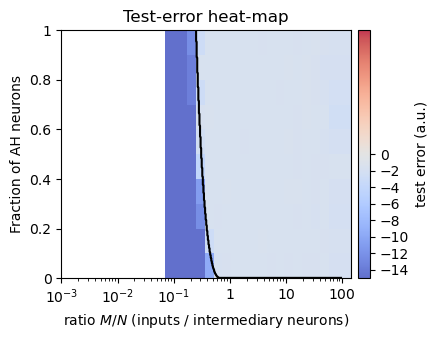

In [170]:
# -------------------------------------------------
#  Helper – edges that match a log-spaced centre list
# -------------------------------------------------
from matplotlib import colors as mcolors   # already imported as `colors`
import matplotlib.patches as mpatches

def relabel_y_as_fraction(ax, full_range, n_ticks=6):
    """
    Show the y-axis as 0→1 while keeping the original data range.

    Parameters
    ----------
    ax          : matplotlib Axes  – the axis to modify
    full_range  : float/int        – top of the raw y-axis (bottom is assumed 0)
    n_ticks     : int              – how many major ticks to place (default 5)
    """
    tick_positions = np.linspace(0, full_range, n_ticks)
    tick_labels    = np.linspace(0, 1, n_ticks)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{t:.2g}" for t in tick_labels])
    
def geom_edges(vals):
    """Return an array of length N+1 whose mid-points are `vals` (length N)."""
    vals = np.asarray(vals, float)
    edges = np.empty(vals.size + 1)

    # interior edges = geometric mean of neighbours
    edges[1:-1] = np.sqrt(vals[:-1] * vals[1:])

    # left & right outer edges – just mirror the first/last ratio
    edges[0]  = vals[0] ** 2 / vals[1]
    edges[-1] = vals[-1] ** 2 / vals[-2]
    return edges


# -------------------------------------------------
#  Heat-map in the same style as the phase diagrams
# -------------------------------------------------
# 1. data

Z = np.array(test_err_nbdat_mean[3]).reshape(len(c_list_L1), len(frac_list)).T   # (rows, cols)
x_edges = geom_edges(c_list_L1)            # len = n_cols + 1
y_edges = np.arange(Z.shape[0] + 1)-1     # regular, 0 … n_rows


vmin, vmax = np.min((-0.1, np.nanmin(Z))), np.nanmax(Z)  
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=np.max((vmax,0.1)))


# 2. figure
fig, ax = plt.subplots(figsize=(4.5, 3.5))

pc = ax.pcolormesh(x_edges, y_edges[1:], Z[1:,:],
                   cmap='coolwarm', shading='auto', alpha = 0.8, norm=norm)      # correct cell widths


X, Ygrid = np.meshgrid(x_vals, y_vals, indexing='ij')
cs = ax.contour(X, Ygrid, Z_th,          # same X,Y,Z you already built
            levels=[0.5],         # 0 → 1 transition
            colors='k',   # pick any colour you like
            linewidths=1.5)



# 3. axes format  (identical to the phase-diagram helper)
ax.set_xscale('log')
xticks = [1e-3, 1e-2, 1e-1, 1, 10, 100]
ax.set_xticks(xticks)
ax.set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$",
                    r"$1$", r"$10$", r"$100$"])
ax.set_xlabel(r"ratio $M/N$ (inputs / intermediary neurons)")

ax.set_ylabel("Fraction of AH neurons")
relabel_y_as_fraction(ax, full_range=Z.shape[0]-1)       # keeps 0 → 1 labelling

# 4. colour-bar, title, tidy up
cbar = fig.colorbar(pc, ax=ax, pad=0.02)
cbar.set_label("test error (log)")

ax.set_title("Test-error heat-map")
plt.tight_layout()

#fig.savefig("test_error_wtheory_heatmap_L1.png", dpi=300, bbox_inches="tight", transparent= True)


# FOR L2

In [207]:
log_indices = log_downsample_indices(nb_epochs, num_points=100)

nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,2,20)
c_list_L2 = np.logspace(-2,1,20)

frac_list = np.linspace(0, 1, num = 11)
tot_neurons = 110

for c in c_list_L2 :
    N = int(tot_neurons/(1+c))
    M = int(tot_neurons/(1+1/c))
    
    for frac_L2 in frac_list:
        nb_AH_layer2 = int(N*frac_L2) # 0
        nb_AH_layer1 = 0#int(M*frac_L1)#0

        filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])
#[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]

for file in filtered_list:
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)
    params_dic, input_list, input_test_list, Ws1_hist_dic, Ws2_hist_dic, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data
    
    nb_data_points = params_dic['nb_data_points']
    nb_test_data_points = params_dic['nb_test_data_points'] 
    input_dim = params_dic['input_dim']
    teacher_size = params_dic['teacher_size']
    student_size = params_dic['student_size']
    nb_AH_layer1 = params_dic['nb_AH_layer1']
    nb_AH_layer2 = params_dic['nb_AH_layer2']
    nb_epochs = params_dic['nb_epochs']
    nb_init = params_dic['nb_init']
    nonlinearity_list = params_dic['nonlinearity_list']
    learning_rate = params_dic['learning_rate']

    nb_datpoints_list.append(nb_data_points)
    error_hist_dic_list.append(error_hist_dic)
    test_error_hist_dic_list.append(test_error_hist_dic)
print(len(filtered_list))

220


In [208]:
lenlist = len(nb_datpoints_list)

err_nbdat_mean = np.zeros((4,lenlist))
err_nbdat_std = np.zeros((4,lenlist))

test_err_nbdat_mean = np.zeros((4,lenlist))
test_err_nbdat_std = np.zeros((4,lenlist))

ts_train_nbdat_mean = np.zeros((4,lenlist))
ts_train_nbdat_std = np.zeros((4,lenlist))

ts_test_nbdat_mean = np.zeros((4,lenlist))
ts_test_nbdat_std = np.zeros((4,lenlist))


timestep = -1
log_indices[timestep]

9999

In [235]:
errors = np.log10(np.array(error_hist_dic_list[0]['GD']))#.round(35)+1e-35)

thresh =-10# -1

ts_blw_thr = find_timestep_below_threshold(errors[0], thresh = thresh)

for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]))#.round(35) + 1e-35)
        ts_train_list = log_indices[np.array([find_timestep_below_threshold(error[k], thresh = thresh) for k in range(error.shape[0])])]
        
        ts_train_nbdat_mean[j,i] = np.nanmean(ts_train_list)
        ts_train_nbdat_std[j,i] = ts_train_list.std()
        
    
        test_error = np.log10(np.array(test_error_hist_dic[label]))#.round(35) + 1e-35)
        ts_test_list = log_indices[np.array([find_timestep_below_threshold(test_error[k], thresh = thresh) for k in range(test_error.shape[0])])]
        
        ts_test_nbdat_mean[j,i] = np.nanmean(ts_test_list)
        ts_test_nbdat_std[j,i] = ts_test_list.std()



In [236]:
for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]))#.round(35) + 1e-35)
        err_mean = np.nanmean(error[:,timestep])
        err_std = error[:,timestep].std()

        err_nbdat_mean[j,i] = err_mean
        err_nbdat_std[j,i] = err_std
        
        
        test_error = np.log10(np.array(test_error_hist_dic[label]))#.round(35) + 1e-35)
        test_err_mean = np.nanmean(test_error[:,timestep])
        test_err_std = test_error[:,timestep].std()

        test_err_nbdat_mean[j,i] = test_err_mean
        test_err_nbdat_std[j,i] = test_err_std

/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/260644483.py:6: RuntimeWarning: Mean of empty slice
  err_mean = np.nanmean(error[:,timestep])
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/260644483.py:14: RuntimeWarning: Mean of empty slice
  test_err_mean = np.nanmean(test_error[:,timestep])


In [237]:
L2_results = np.load('L2_results.npy', allow_pickle = True)
mask_mat_all_stable_L2, mask_mat_some_stable_L2, AH_L2_frac_list, AH_L2_upper_frac_list = L2_results

Z_th = mask_mat_all_stable_L2.astype(int) 
x_vals = np.logspace(-3, 2, num=500)
y_vals = np.linspace(0,10, mask_mat_all_stable_L2.shape[1])

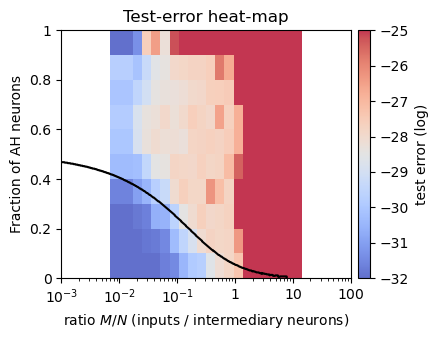

In [253]:
# -------------------------------------------------
#  Helper – edges that match a log-spaced centre list
# -------------------------------------------------
from matplotlib import colors as mcolors   # already imported as `colors`
import matplotlib.patches as mpatches

def relabel_y_as_fraction(ax, full_range, n_ticks=6):
    """
    Show the y-axis as 0→1 while keeping the original data range.

    Parameters
    ----------
    ax          : matplotlib Axes  – the axis to modify
    full_range  : float/int        – top of the raw y-axis (bottom is assumed 0)
    n_ticks     : int              – how many major ticks to place (default 5)
    """
    tick_positions = np.linspace(0, full_range, n_ticks)
    tick_labels    = np.linspace(0, 1, n_ticks)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{t:.2g}" for t in tick_labels])
    
def geom_edges(vals):
    """Return an array of length N+1 whose mid-points are `vals` (length N)."""
    vals = np.asarray(vals, float)
    edges = np.empty(vals.size + 1)

    # interior edges = geometric mean of neighbours
    edges[1:-1] = np.sqrt(vals[:-1] * vals[1:])

    # left & right outer edges – just mirror the first/last ratio
    edges[0]  = vals[0] ** 2 / vals[1]
    edges[-1] = vals[-1] ** 2 / vals[-2]
    return edges


# -------------------------------------------------
#  Heat-map in the same style as the phase diagrams
# -------------------------------------------------
# 1. data

Z = np.array(test_err_nbdat_mean[3]).reshape(len(c_list_L2), len(frac_list)).T   # (rows, cols)
x_edges = geom_edges(c_list_L2)            # len = n_cols + 1
y_edges = np.arange(Z.shape[0] + 1)-1     # regular, 0 … n_rows


vmin, vmax = (-2.5,0.1)#np.min((-0.1, np.nanmin(Z))), np.nanmax(Z)  
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=np.max((vmax,0.1)))


# 2. figure
fig, ax = plt.subplots(figsize=(4.5, 3.5))

pc = ax.pcolormesh(x_edges, y_edges[1:], Z[1:,:],
                   cmap='coolwarm', shading='auto', alpha = 0.8, vmin = -32, vmax = -25)#, norm=norm)      # correct cell widths


X, Ygrid = np.meshgrid(x_vals, y_vals, indexing='ij')
cs = ax.contour(X, Ygrid, Z_th,          # same X,Y,Z you already built
            levels=[0.5],         # 0 → 1 transition
            colors='k',   # pick any colour you like
            linewidths=1.5)



# 3. axes format  (identical to the phase-diagram helper)
ax.set_xscale('log')
xticks = [1e-3, 1e-2, 1e-1, 1, 10, 100]
ax.set_xticks(xticks)
ax.set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$",
                    r"$1$", r"$10$", r"$100$"])
ax.set_xlabel(r"ratio $M/N$ (inputs / intermediary neurons)")

ax.set_ylabel("Fraction of AH neurons")
relabel_y_as_fraction(ax, full_range=Z.shape[0]-1)       # keeps 0 → 1 labelling

# 4. colour-bar, title, tidy up
cbar = fig.colorbar(pc, ax=ax, pad=0.02)
cbar.set_label("test error (log)")

ax.set_title("Test-error heat-map")
plt.tight_layout()

#fig.savefig("ts_test_error_wtheory_heatmap_L2_small.png", dpi=300, bbox_inches="tight", transparent= True)


# Mix of AHL1 and AHL2 for c = 0.1

In [142]:
log_indices = log_downsample_indices(nb_epochs, num_points=100)

nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,2,20)
c_list_L2 = np.logspace(-2,1,20)

frac_list = np.linspace(0, 1, num = 11)
tot_neurons = 110

c = 0.1
N = int(tot_neurons/(1+c))
M = int(tot_neurons/(1+1/c))


for frac_L1 in frac_list:
    nb_AH_layer1 = int(M*frac_L1)
    for frac_L2 in frac_list:
        nb_AH_layer2 = int(N*frac_L2)

        filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])
#[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]

for file in filtered_list:
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)
    params_dic, input_list, input_test_list, Ws1_hist_dic, Ws2_hist_dic, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data
    
    nb_data_points = params_dic['nb_data_points']
    nb_test_data_points = params_dic['nb_test_data_points'] 
    input_dim = params_dic['input_dim']
    teacher_size = params_dic['teacher_size']
    student_size = params_dic['student_size']
    nb_AH_layer1 = params_dic['nb_AH_layer1']
    nb_AH_layer2 = params_dic['nb_AH_layer2']
    nb_epochs = params_dic['nb_epochs']
    nb_init = params_dic['nb_init']
    nonlinearity_list = params_dic['nonlinearity_list']
    learning_rate = params_dic['learning_rate']

    nb_datpoints_list.append(nb_data_points)
    error_hist_dic_list.append(error_hist_dic)
    test_error_hist_dic_list.append(test_error_hist_dic)
print(len(filtered_list))

121


In [143]:
lenlist = len(nb_datpoints_list)

err_nbdat_mean = np.zeros((4,lenlist))
err_nbdat_std = np.zeros((4,lenlist))

test_err_nbdat_mean = np.zeros((4,lenlist))
test_err_nbdat_std = np.zeros((4,lenlist))

ts_train_nbdat_mean = np.zeros((4,lenlist))
ts_train_nbdat_std = np.zeros((4,lenlist))

ts_test_nbdat_mean = np.zeros((4,lenlist))
ts_test_nbdat_std = np.zeros((4,lenlist))


timestep = -1
log_indices[timestep]

9999

In [153]:
errors = np.log10(np.array(error_hist_dic_list[0]['GD']).round(15)+1e-15)

thresh =-10# -1

ts_blw_thr = find_timestep_below_threshold(errors[0], thresh = thresh)

for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        ts_train_list = log_indices[np.array([find_timestep_below_threshold(error[k], thresh = thresh) for k in range(error.shape[0])])]
        
        ts_train_nbdat_mean[j,i] = np.nanmean(ts_train_list)
        ts_train_nbdat_std[j,i] = ts_train_list.std()
        
    
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        ts_test_list = log_indices[np.array([find_timestep_below_threshold(test_error[k], thresh = thresh) for k in range(test_error.shape[0])])]
        
        ts_test_nbdat_mean[j,i] = np.nanmean(ts_test_list)
        ts_test_nbdat_std[j,i] = ts_test_list.std()



/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/1560442182.py:11: RuntimeWarning: overflow encountered in multiply
  error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/1560442182.py:18: RuntimeWarning: overflow encountered in multiply
  test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)


In [154]:
for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        err_mean = np.nanmean(error[:,timestep])
        err_std = error[:,timestep].std()

        err_nbdat_mean[j,i] = err_mean
        err_nbdat_std[j,i] = err_std
        
        
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        test_err_mean = np.nanmean(test_error[:,timestep])
        test_err_std = test_error[:,timestep].std()

        test_err_nbdat_mean[j,i] = test_err_mean
        test_err_nbdat_std[j,i] = test_err_std

/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:6: RuntimeWarning: Mean of empty slice
  err_mean = np.nanmean(error[:,timestep])
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:14: RuntimeWarning: Mean of empty slice
  test_err_mean = np.nanmean(test_error[:,timestep])
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:5: RuntimeWarning: overflow encountered in multiply
  error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:13: RuntimeWarning: overflow encountered in multiply
  test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)


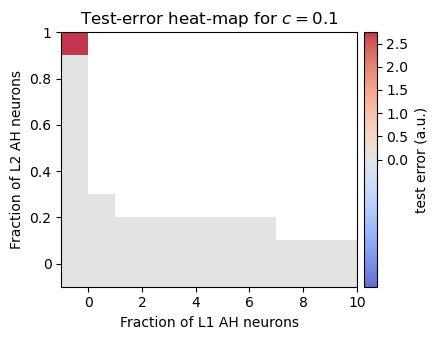

In [155]:
# -------------------------------------------------
#  Helper – edges that match a log-spaced centre list
# -------------------------------------------------
from matplotlib import colors as mcolors   # already imported as `colors`
import matplotlib.patches as mpatches

def relabel_y_as_fraction(ax, full_range, n_ticks=6):
    """
    Show the y-axis as 0→1 while keeping the original data range.

    Parameters
    ----------
    ax          : matplotlib Axes  – the axis to modify
    full_range  : float/int        – top of the raw y-axis (bottom is assumed 0)
    n_ticks     : int              – how many major ticks to place (default 5)
    """
    tick_positions = np.linspace(0, full_range, n_ticks)
    tick_labels    = np.linspace(0, 1, n_ticks)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{t:.2g}" for t in tick_labels])
    
def geom_edges(vals):
    """Return an array of length N+1 whose mid-points are `vals` (length N)."""
    vals = np.asarray(vals, float)
    edges = np.empty(vals.size + 1)

    # interior edges = geometric mean of neighbours
    edges[1:-1] = np.sqrt(vals[:-1] * vals[1:])

    # left & right outer edges – just mirror the first/last ratio
    edges[0]  = vals[0] ** 2 / vals[1]
    edges[-1] = vals[-1] ** 2 / vals[-2]
    return edges


# -------------------------------------------------
#  Heat-map in the same style as the phase diagrams
# -------------------------------------------------
# 1. data

Z = np.array(test_err_nbdat_mean[3]-test_err_nbdat_mean[0]).reshape(len(frac_list), len(frac_list)).T   # (rows, cols)
x_edges = np.arange(Z.shape[1]+1) - 1
y_edges = np.arange(Z.shape[0] + 1) - 1     # regular, 0 … n_rows


vmin, vmax = np.min((-0.1, np.nanmin(Z))), np.nanmax(Z)  
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=np.max((vmax,0.1)))


# 2. figure
fig, ax = plt.subplots(figsize=(4.5, 3.5))

pc = ax.pcolormesh(x_edges, y_edges, Z,
                   cmap='coolwarm', shading='auto', alpha = 0.8, norm=norm)      # correct cell widths



# 3. axes format  (identical to the phase-diagram helper)
#ax.set_xscale('log')
#xticks = [1e-3, 1e-2, 1e-1, 1, 10, 100]
#ax.set_xticks(xticks)
#ax.set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$",
#                    r"$1$", r"$10$", r"$100$"])
ax.set_xlabel("Fraction of L1 AH neurons")

ax.set_ylabel("Fraction of L2 AH neurons")
relabel_y_as_fraction(ax, full_range=Z.shape[0]-1)       # keeps 0 → 1 labelling

# 4. colour-bar, title, tidy up
cbar = fig.colorbar(pc, ax=ax, pad=0.02)
cbar.set_label("test error (log)")

ax.set_title(f"Test-error heat-map for $c={c}$")
plt.tight_layout()

#fig.savefig("test_error_wtheory_heatmap_L1L2_c=0.1.png", dpi=300, bbox_inches="tight", transparent= True)


# Mix of AHL1 and AHL2 for c = 10

In [156]:
log_indices = log_downsample_indices(nb_epochs, num_points=100)

nb_datpoints_list = []
error_hist_dic_list = []
test_error_hist_dic_list = []

#for run_nb in range(33,44):
#    with open(f'run_tanh_uniform_{run_nb}.pkl', 'rb') as f:
#        loaded_data = pickle.load(f)


filtered_list = []
c_list_L1 = np.logspace(-1,2,20)
c_list_L2 = np.logspace(-2,1,20)

frac_list = np.linspace(0, 1, num = 11)
tot_neurons = 110

c = 10
N = int(tot_neurons/(1+c))
M = int(tot_neurons/(1+1/c))


for frac_L1 in frac_list:
    nb_AH_layer1 = int(M*frac_L1)
    for frac_L2 in frac_list:
        nb_AH_layer2 = int(N*frac_L2)

        filtered_list.append([item for item in pkl_files if item.startswith(f'run_{nb_AH_layer1}-{M}__{nb_AH_layer2}-{N}')][0])
#[item for item in pkl_files if item.startswith('run_lin_uniform_1.')]

for file in filtered_list:
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)
    params_dic, input_list, input_test_list, Ws1_hist_dic, Ws2_hist_dic, error_hist_dic, test_error_hist_dic, teacher_params = loaded_data
    
    nb_data_points = params_dic['nb_data_points']
    nb_test_data_points = params_dic['nb_test_data_points'] 
    input_dim = params_dic['input_dim']
    teacher_size = params_dic['teacher_size']
    student_size = params_dic['student_size']
    nb_AH_layer1 = params_dic['nb_AH_layer1']
    nb_AH_layer2 = params_dic['nb_AH_layer2']
    nb_epochs = params_dic['nb_epochs']
    nb_init = params_dic['nb_init']
    nonlinearity_list = params_dic['nonlinearity_list']
    learning_rate = params_dic['learning_rate']

    nb_datpoints_list.append(nb_data_points)
    error_hist_dic_list.append(error_hist_dic)
    test_error_hist_dic_list.append(test_error_hist_dic)
print(len(filtered_list))

121


In [157]:
lenlist = len(nb_datpoints_list)

err_nbdat_mean = np.zeros((4,lenlist))
err_nbdat_std = np.zeros((4,lenlist))

test_err_nbdat_mean = np.zeros((4,lenlist))
test_err_nbdat_std = np.zeros((4,lenlist))

ts_train_nbdat_mean = np.zeros((4,lenlist))
ts_train_nbdat_std = np.zeros((4,lenlist))

ts_test_nbdat_mean = np.zeros((4,lenlist))
ts_test_nbdat_std = np.zeros((4,lenlist))


timestep = -1
log_indices[timestep]

9999

In [158]:
errors = np.log10(np.array(error_hist_dic_list[0]['GD']).round(15)+1e-15)

thresh =-10# -1

ts_blw_thr = find_timestep_below_threshold(errors[0], thresh = thresh)

for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        ts_train_list = log_indices[np.array([find_timestep_below_threshold(error[k], thresh = thresh) for k in range(error.shape[0])])]
        
        ts_train_nbdat_mean[j,i] = np.nanmean(ts_train_list)
        ts_train_nbdat_std[j,i] = ts_train_list.std()
        
    
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        ts_test_list = log_indices[np.array([find_timestep_below_threshold(test_error[k], thresh = thresh) for k in range(test_error.shape[0])])]
        
        ts_test_nbdat_mean[j,i] = np.nanmean(ts_test_list)
        ts_test_nbdat_std[j,i] = ts_test_list.std()



/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/1560442182.py:11: RuntimeWarning: overflow encountered in multiply
  error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/1560442182.py:18: RuntimeWarning: overflow encountered in multiply
  test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)


In [159]:
for i in range(lenlist):
    error_hist_dic = error_hist_dic_list[i]
    test_error_hist_dic = test_error_hist_dic_list[i]
    for j,label in enumerate(label_list):
        error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
        err_mean = np.nanmean(error[:,timestep])
        err_std = error[:,timestep].std()

        err_nbdat_mean[j,i] = err_mean
        err_nbdat_std[j,i] = err_std
        
        
        test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)
        test_err_mean = np.nanmean(test_error[:,timestep])
        test_err_std = test_error[:,timestep].std()

        test_err_nbdat_mean[j,i] = test_err_mean
        test_err_nbdat_std[j,i] = test_err_std

/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:6: RuntimeWarning: Mean of empty slice
  err_mean = np.nanmean(error[:,timestep])
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:14: RuntimeWarning: Mean of empty slice
  test_err_mean = np.nanmean(test_error[:,timestep])
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:5: RuntimeWarning: overflow encountered in multiply
  error = np.log10(np.array(error_hist_dic[label]).round(15) + 1e-15)
/var/folders/tz/7jgtwmdx0rzbplvnb9_wvmp00000gp/T/ipykernel_86573/836847469.py:13: RuntimeWarning: overflow encountered in multiply
  test_error = np.log10(np.array(test_error_hist_dic[label]).round(15) + 1e-15)


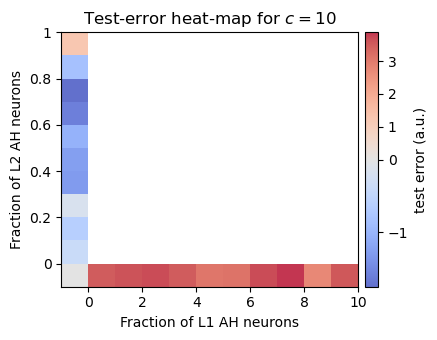

In [160]:
# -------------------------------------------------
#  Helper – edges that match a log-spaced centre list
# -------------------------------------------------
from matplotlib import colors as mcolors   # already imported as `colors`
import matplotlib.patches as mpatches

def relabel_y_as_fraction(ax, full_range, n_ticks=6):
    """
    Show the y-axis as 0→1 while keeping the original data range.

    Parameters
    ----------
    ax          : matplotlib Axes  – the axis to modify
    full_range  : float/int        – top of the raw y-axis (bottom is assumed 0)
    n_ticks     : int              – how many major ticks to place (default 5)
    """
    tick_positions = np.linspace(0, full_range, n_ticks)
    tick_labels    = np.linspace(0, 1, n_ticks)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{t:.2g}" for t in tick_labels])
    
def geom_edges(vals):
    """Return an array of length N+1 whose mid-points are `vals` (length N)."""
    vals = np.asarray(vals, float)
    edges = np.empty(vals.size + 1)

    # interior edges = geometric mean of neighbours
    edges[1:-1] = np.sqrt(vals[:-1] * vals[1:])

    # left & right outer edges – just mirror the first/last ratio
    edges[0]  = vals[0] ** 2 / vals[1]
    edges[-1] = vals[-1] ** 2 / vals[-2]
    return edges


# -------------------------------------------------
#  Heat-map in the same style as the phase diagrams
# -------------------------------------------------
# 1. data

Z = np.array(test_err_nbdat_mean[3]-test_err_nbdat_mean[0]).reshape(len(frac_list), len(frac_list)).T   # (rows, cols)
x_edges = np.arange(Z.shape[1]+1) - 1
y_edges = np.arange(Z.shape[0] + 1) - 1     # regular, 0 … n_rows


vmin, vmax = np.min((-0.1, np.nanmin(Z))), np.nanmax(Z)  
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=np.max((vmax,0.1)))


# 2. figure
fig, ax = plt.subplots(figsize=(4.5, 3.5))

pc = ax.pcolormesh(x_edges, y_edges, Z,
                   cmap='coolwarm', shading='auto', alpha = 0.8, norm=norm)      # correct cell widths



# 3. axes format  (identical to the phase-diagram helper)
#ax.set_xscale('log')
#xticks = [1e-3, 1e-2, 1e-1, 1, 10, 100]
#ax.set_xticks(xticks)
#ax.set_xticklabels([r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$",
#                    r"$1$", r"$10$", r"$100$"])
ax.set_xlabel("Fraction of L1 AH neurons")

ax.set_ylabel("Fraction of L2 AH neurons")
relabel_y_as_fraction(ax, full_range=Z.shape[0]-1)       # keeps 0 → 1 labelling

# 4. colour-bar, title, tidy up
cbar = fig.colorbar(pc, ax=ax, pad=0.02)
cbar.set_label("test error (log)")

ax.set_title(f"Test-error heat-map for $c={c}$")
plt.tight_layout()

#fig.savefig("test_error_wtheory_heatmap_L1L2_c=0.1.png", dpi=300, bbox_inches="tight", transparent= True)


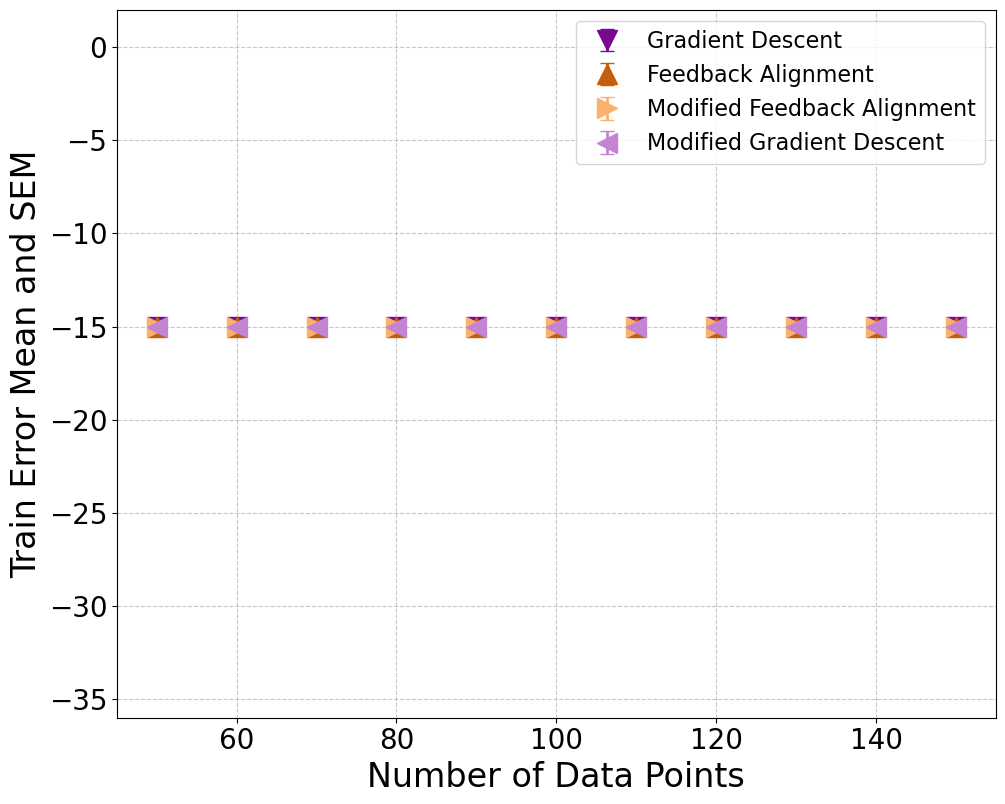

In [605]:
label_list_mod = ['Gradient Descent', 'Feedback Alignment', 'Modified Feedback Alignment', 'Modified Gradient Descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, err_nbdat_mean[i, :], yerr=err_nbdat_std[i, :] / np.sqrt(error.shape[0]),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

plt.ylabel('Train Error Mean and SEM', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.ylim(-36,2)
plt.tick_params(axis='both', which='major', labelsize=20)
# Uncomment the following line if you want to save the figure
#plt.savefig('scientific_plot_train_error_tanh_expL1.pdf', dpi=300, bbox_inches='tight')

plt.show()

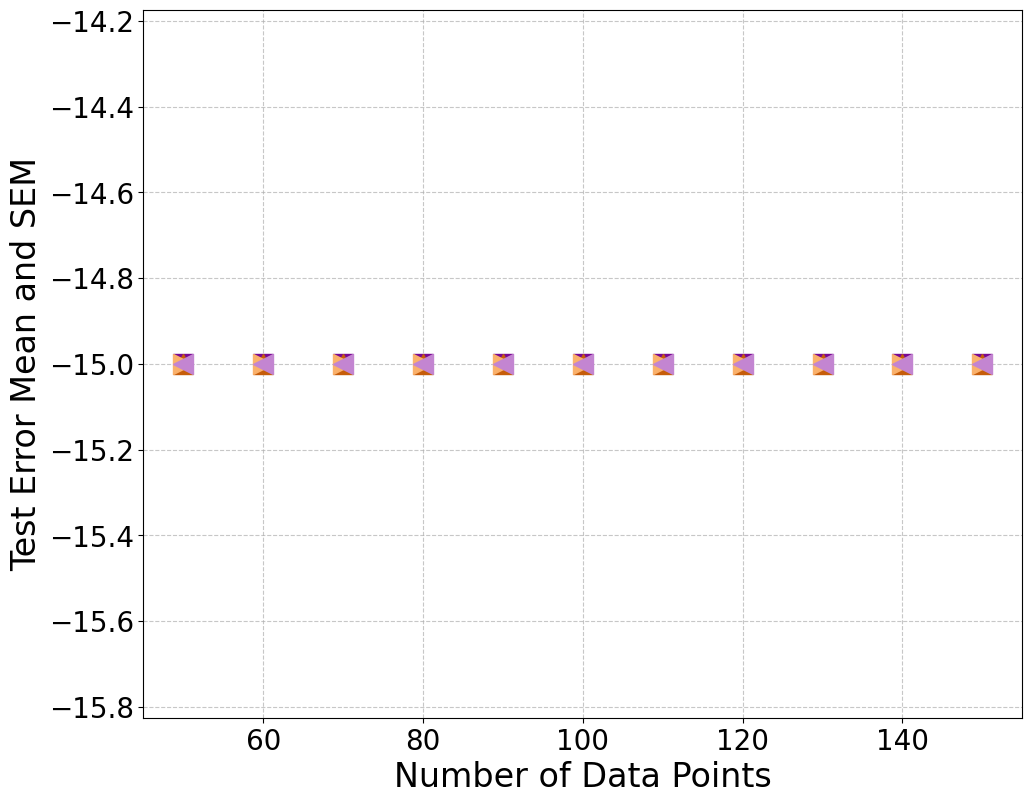

In [606]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming label_list, nb_datpoints_list, test_err_nbdat_mean, test_err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, test_err_nbdat_mean[i, :], yerr=test_err_nbdat_std[i, :] / np.sqrt(error.shape[0]),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
    
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth = 2)

plt.ylabel('Test Error Mean and SEM', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
#plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=20)


# Uncomment the following line if you want to save the figure
#plt.savefig('scientific_plot_test_error_tanh_expL1.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [607]:
ts_train_nbdat_mean

array([[15.4, 16.6, 15.7, 19.3, 32.8, 21.9, 19.3, 22.7, 20.4, 21.1, 20.6],
       [18.2, 19.6, 18.5, 21.8, 37.8, 24.9, 23.4, 25.7, 23.3, 23.9, 23.8],
       [18.9, 19.7, 18.8, 21.5, 37.6, 24.6, 23.1, 25.3, 24.1, 24.3, 23.8],
       [16.5, 17.1, 16.5, 19.6, 34.1, 22.6, 20.4, 22.8, 21.2, 22.8, 23.2]])

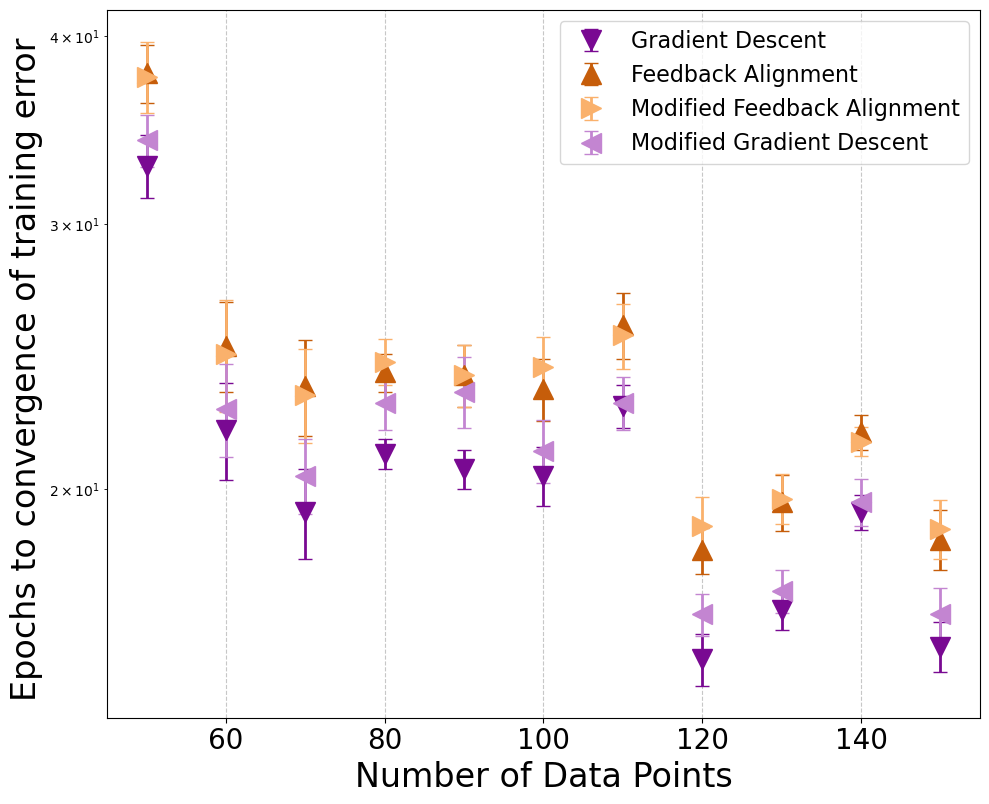

In [608]:
label_list_mod = ['Gradient Descent', 'Feedback Alignment', 'Modified Feedback Alignment', 'Modified Gradient Descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, ts_train_nbdat_mean[i, :], yerr=ts_train_nbdat_std[i, :] / np.sqrt(nb_init),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

plt.yscale('log')

plt.ylabel('Epochs to convergence of training error ', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.ylim(-36,2)
plt.tick_params(axis='both', which='major', labelsize=20)
# Uncomment the following line if you want to save the figure
#plt.savefig('tanh_train_tocv_expL1.pdf', dpi=300, bbox_inches='tight')

plt.show()

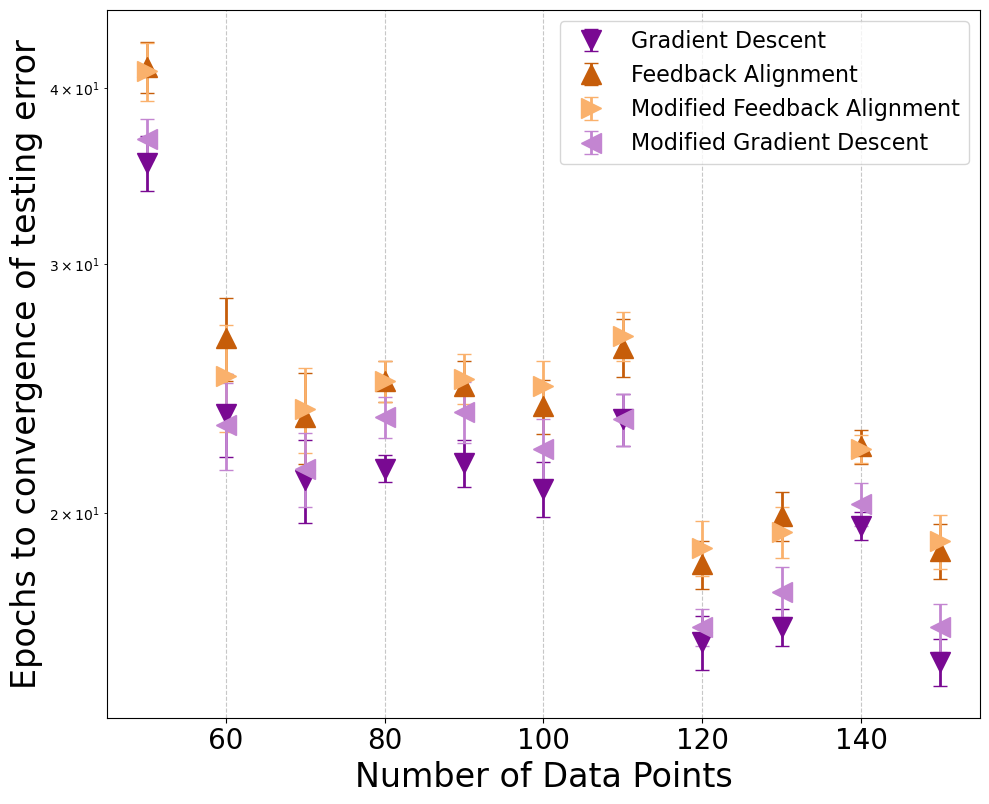

In [609]:
label_list_mod = ['Gradient Descent', 'Feedback Alignment', 'Modified Feedback Alignment', 'Modified Gradient Descent']
fmt_list = ['v','^','>','<']

# Assuming label_list, nb_datpoints_list, err_nbdat_mean, err_nbdat_std, error, color_list,
# input_dim, student_size, nb_AH_layer1, nb_AH_layer2, log_indices, timestep,
# nonlinearity_list, and learning_rate are already defined

plt.figure(figsize=(10, 8))

for i, label in enumerate(label_list_mod):
    plt.errorbar(nb_datpoints_list, ts_test_nbdat_mean[i, :], yerr=ts_test_nbdat_std[i, :] / np.sqrt(nb_init),
                 fmt=fmt_list[i], color=color_list[i], label=label, capsize=5, elinewidth=2, markersize=14)
# Add the vertical dashed line at x=110
#plt.axvline(x=100, color='gray', linestyle='--', label='Number of Input Neurons', linewidth =2)

plt.yscale('log')

plt.ylabel('Epochs to convergence of testing error', fontsize=24)
plt.xlabel('Number of Data Points', fontsize=24)
#plt.title(f'Nb Inputs: {input_dim}, Student Size: {student_size}, Nb Inhib L1: {nb_AH_layer1}, '
#          f'Nb Inhib L2: {nb_AH_layer2}, Nb Epochs: {log_indices[timestep]}, '
#          f'Nonlinearity: {nonlinearity_list[0]}, Learning Rate: {learning_rate}', fontsize=16)
plt.legend(fontsize=16, frameon=True, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.ylim(0,1e5)
plt.tick_params(axis='both', which='major', labelsize=20)
# Uncomment the following line if you want to save the figure
#plt.savefig('tanh_test_to_cv_expL1.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [618]:
int(110/(1+10))

10

In [619]:
int(110/(1+10))

10